

<br>
<br>


<h1><center> SFS </center></h1>


<br>
<br>


#### Signal Formation Simulation
The idea is to develop a lightweight and easy-to-use tool for the top-down how affects the performance of the next-generation dark matter detector.
The code is based on the Noble Element Simulation Technique (NEST).


<br>
<br>


#### This Notebook
This is the notebook that was used to actually conduct the study.
It is supposed to further serve as documentation of the ''sfs.py'' library. Feel free to copy the exemplary function calls below into your personal study project.


<br>
<br>


#### Contents


1. **[Setup](#Setup)**
2. **[Imports and Definitions](#Imports-and-Definitions)**
3. **[Detector Definition](#Detector-Definition)**
4. **[Spectra Definition](#Spectra-Definition)**
5. **[Executing NEST](#Executing-NEST)**
6. **[ER/NR Discrimination](#ER/NR-Discrimination)**
7. **[Maximum Likelihood Sensitivity Estimation](#Maximum-Likelihood-Sensitivity-Estimation)**


<br>
<br>


#### Credits
- NEST collaboration
- C. Hock


<br>
<br>



<br>
<br>


# Setup


<br>
<br>


- install NEST following their official documentation


- Store the absolute path of the NEST installation, i.e., the directory containing the `nest`, `install`, and `build` directories, in an environmental variable. Therefore execute:<br> `$ echo 'export ABSPATH_NEST_INSTALLATION="/abspath/to/your/nest/root/directory/" >> ~/.bashrc'`


- git clone the ''sfsv2'' repository


- edit the ''sfs.py'' file


<br>
<br>



<br>
<br>


# Imports and Definitions


<br>
<br>


In [1]:

# imports <---- check which one of those are actually needed
import subprocess
import numpy as np
import matplotlib.pyplot as plt


# path definitions
abspath_sfs_repo = "/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/"
abspath_study = abspath_sfs_repo # you'll probably have different paths for 'abspath_sfs_repo' and 'abspath_study'
abspath_detectors = abspath_study +"detectors/"
abspath_spectra = abspath_study +"spectra/"
abspath_resources = abspath_study +"resources/"
abspath_list_plots = [abspath_study +"plots/", "/home/daniel/Desktop/arbeitsstuff/thesis/images/sfs/"]
abspath_signatures = abspath_study +"signatures/"


# importing my personal matplotlib style file
import matplotlib as mpl
plt.style.use("file:///home/daniel/Desktop/arbeitsstuff/monxe/software/miscfig/danielsmplstyle.mplstyle")


# importing the sfs library
import sys
sys.path.append(abspath_sfs_repo)
import sfs



<br>
<br>


# Detector Definition


<br>
<br>


In [2]:


# defining the 'detector_dict'
darwin_baseline_detector_dict = {
    # primary scintillation (S1) parameters
    "g1"                : 0.12,                     # phd per S1 phot at dtCntr (not phe), divide out 2-PE effect,                          JN: 0.119, LUX_Run03: 0.1170 (0.117+/-0.003 WS,0.115+/-0.005 D-D,0.115+/-0.005 CH3T,0.119+/-0.001 LUXSim), XENON10: 0.073
    "sPEres"            : 0.37,                     # single phe (=PE=photoelectrons) resolution (Gaussian assumed),                        JN: 0.38, LUX_Run03: 0.37 (arXiv:1910.04211.), XENON10: 0.58
    "sPEthr"            : 0.35,                     # POD threshold in phe, usually used IN PLACE of sPEeff,                                JN: 0.35, LUX_Run03: (0.3 * 1.173) / 0.915 (arXiv:1910.04211.), XENON10: 0.35
    "sPEeff"            : 0.9,                      # actual efficiency, can be used in lieu of POD threshold, units: fractional,           JN: 0.90, LUX_Run03: 1.00 (arXiv:1910.04211), XENON10: 1.00
    "noiseBaseline[0]"  : 0.0,                      # baseline noise mean in PE (Gaussian),                                                 JN: 0.0, LUX_Run03: 0.00 (arXiv:1910.04211 says -0.01), XENON10: 0.0
    "noiseBaseline[1]"  : 0.0,                      # baseline noise width in PE (Gaussian),                                                JN: 0.0, LUX_Run03: 0.08 (arXiv:1910.04211), XENON10: 0.0
    "noiseBaseline[2]"  : 0.0,                      # baseline noise mean in e- (for grid wires),                                           JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "noiseBaseline[3]"  : 0.0,                      # baseline noise width in e- (for grid wires),                                          JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "P_dphe"            : 0.2,                      # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT, units: fractional,         JN: 0.22, LUX_Run03: 0.173 (arXiv:1910.04211), XENON10: 0.2
    "coinWind"          : 100,                      # S1 coincidence window in ns,                                                          JN: 100, LUX_Run03: 100 (1310.8214), XENON10: 100
    "coinLevel"         : 3,                        # how many PMTs have to fire for an S1 to count,                                        JN: 3, LUX_Run03: 2 (1512.03506), XENON10: 2
    "numPMTs"           : 494,                      # for coincidence calculation,                                                          JN: 494, LUX_Run03: 119 (122 minus 3 off), XENON10: 89
    "OldW13eV"          : "true",                   # default true, which means use "classic" W instead of Baudis / EXO's,                  JN: none, LUX_Run03: "true", XENON10: "true"
    "noiseLinear[0]"    : 0.0e-2,                   # S1->S1 Gaussian-smeared with noiseL[0]*S1, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    "noiseLinear[1]"    : 0.0e-2,                   # S2->S2 Gaussian-smeared with noiseL[1]*S2, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    # ionization and secondary scintillation (S2) parameters
    "g1_gas"            : 0.1,                      # phd per S2 photon in gas, used to get SE size, units: phd per e-,                     JN: 0.102, LUX_Run03: 0.1 (0.1 in 1910.04211), XENON10: 0.0655
    "s2Fano"            : 3.6,                      # Fano-like fudge factor for SE width, dimensionless,                                   JN: 3.61, LUX_Run03: 3.6 (3.7 in 1910.04211; this matches 1608.05381 better), XENON10: 3.61
    "s2_thr"            : -100,                      # the S2 threshold in phe or PE, *not* phd. Affects NR most,                            JN: 100.0, LUX_Run03: (150.0 * 1.173) / 0.915 (65-194 pe in 1608.05381), XENON10: 300.0
    "E_gas"             : 10.0,                     # field in kV/cm between liquid/gas border and anode,                                   JN: 10.85, LUX_Run03: 6.25 (6.55 in 1910.04211), XENON10: 12.0
    "eLife_us"          : 5000.0,                   # the drift electron mean lifetime in micro-seconds,                                    JN: 1600.0, LUX_Run03: 800.0 (p.44 of James Verbus PhD thesis Brown), XENON10: 2200.0
    # thermodynamic properties
#    "inGas"             : "false",                  # (duh),                                                                               JN: "false", LUX_Run03: commented out, XENON10: "false"
    "T_Kelvin"          : 175.0,                    # for liquid drift speed calculation, temperature in Kelvin,                            JN: 175.0, LUX_Run03: 173.0 (1910.04211), XENON10: 177.0
    "p_bar"             : 2.0,                      # gas pressure in units of bars, it controls S2 size,                                   JN: 2.0, LUX_Run03: 1.57 (1910.04211), XENON10: 2.14
    # data analysis parameters and geometry
    "dtCntr"            : 822.0,                    # center of detector for S1 corrections, in usec.,                                      JN: 822.0, LUX_Run03: 160.0 (p.61 Dobi thesis UMD, 159 in 1708.02566), XENON10: 40.0
    "dt_min"            : 75.8,                     # minimum. Top of detector fiducial volume, units: microseconds,                        JN: 75.8, LUX_Run03: 38.0 (1608.05381), XENON10: 20.0
    "dt_max"            : 1536.5,                   # maximum. Bottom of detector fiducial volume, units: microseconds,                     JN: 1536.5, LUX_Run03: 305.0 (1608.05381), XENON10: 60.0
    "radius"            : 1300.0,                   # millimeters (fiducial rad), units: millimeters,                                       JN: 1300., LUX_Run03: 200.0 (1512.03506), XENON10: 50.0
    "radmax"            : 1350.0,                   # actual physical geo. limit, units: millimeters,                                       JN: 1350., LUX_Run03: 235.0 (1910.04211), XENON10: 50.0
    "TopDrift"          : 3005.0,                   # top of drif volume in mm not cm or us, i.e., this *is* where dt=0, z=0mm is cathode,  JN: 3005.0, LUX_Run03: 544.95 (544.95 in 1910.04211), XENON10: 150.0
    "anode"             : 3012.5,                   # the level of the anode grid-wire plane in mm,                                         JN: 3012.5, LUX_Run03: 549.2 (1910.04211 and 549 in 1708.02566), XENON10: 152.5
    "gate"              : 3000.0,                   # mm. this is where the E-field changes (higher),                                       JN: 3000.0, LUX_Run03: 539.2 (1910.04211 and 539 in 1708.02566), XENON10: 147.5
    "cathode"           : 250.0,                    # mm. defines point below which events are gamma-X                                      JN: 250, LUX_Run03: 55.90 (55.9-56 in 1910.04211,1708.02566), XENON10: 1.00
    # 2D (xy) position reconstruction
    "PosResExp"         : 0.015,                    # exp increase in pos recon res at hi r, units: 1/mm,                                   JN: 0.015, LUX_Run03: 0.015 (arXiv:1710.02752 indirectly), XENON10: 0.015
    "PosResBase"        : 30.,                      # baseline unc in mm, see NEST.cpp for usage,                                           JN: 30.0, LUX_Run03: 70.8364 ((1710.02752 indirectly), XEONON10: 70.8364
}

# computing the corresponding g2 value


# implementing and installing the 'detector_dict' within local NEST installation








<br>
<br>


# Spectra Definition


<br>
<br>



#### assumptions

In [3]:
darwin_default_drift_field_v_cm = 200
exposure_t_y = 40*5
wimp_eroi_kev_ee = [1.4, 10.6]
wimp_eroi_kev_nr = [4.9, 40.9]
recoil_energy_simulation_window_er = [0, wimp_eroi_kev_ee[1]*1.5]
recoil_energy_simulation_window_nr = [0, wimp_eroi_kev_nr[1]*1.5]
simulation_energy_bins = 50



#### differential ER and NR backgrounds
WIMPs are computed with [Jelle Aalber's `wimprates` library](https://github.com/JelleAalbers/wimprates).

In [4]:


if [False,True][0]:


    sfs.gen_spectrum_plot(
        spectra_list = ["er_pp", "er_be7", "er_cno", "er_nunubetabeta", "combined_er_background"],
        abspath_spectra_files = abspath_resources,
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][2],
        plot_log_y_axis = True,
        plot_log_x_axis = True,
        plot_xlim = [1e+0,4e+3],
        plot_ylim = [3.5e-3,3.5e+2],
        plot_legend_bbox_to_anchor = [0.75, 0.55, 0.25, 0.45],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 6,
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__spectrum_plot__differential_combined_er_background.png",
        flag_shade_wimp_eroi = wimp_eroi_kev_ee,
        flag_verbose = True,)


    sfs.gen_spectrum_plot(
        #spectra_list = ["nr_wimps_nat_xe", "nr_wimps_wimprates", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
        spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
        abspath_spectra_files = abspath_resources,
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][1],
        plot_log_y_axis = True,
        plot_log_x_axis = True,
        plot_xlim = [1e-3,1e+2],
        plot_ylim = [5e-4,5e+3],
        plot_legend_bbox_to_anchor = [0.75, 0.27, 0.25, 0.73],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 6,
        flag_output_abspath_list = abspath_list_plots,
        flag_shade_wimp_eroi = wimp_eroi_kev_nr,
        flag_output_filename = "example__spectrum_plot__differential_combined_nr_background_wimps.png",
        flag_verbose = True,)



#### histogrammed ER and NR background spectra

In [5]:


if [False,True][0]:


    # generating the ER background spectrum dict
    er_background_spectrum_dict = sfs.give_spectrum_dict(
        spectrum_name = "combined_er_background",
        recoil_energy_kev_list = sfs.bin_centers_from_interval(recoil_energy_simulation_window_er, simulation_energy_bins),
        # 
        abspath_spectra_files = abspath_resources,
        exposure_t_y = exposure_t_y,
        num_events = -1,
        # nest parameters
        seed = 0,
        drift_field_v_cm = darwin_default_drift_field_v_cm,
        xyz_pos_mm = "-1 -1 -1",
        # flags
        flag_spectrum_type = ["differential", "integral"][1],
        flag_verbose = False,
        # keywords
        spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
        #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
    )
    sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background.json", er_background_spectrum_dict)


    # generating the NR background spectrum dict
    nr_background_spectrum_dict = sfs.give_spectrum_dict(
        spectrum_name = "combined_nr_background",
        recoil_energy_kev_list = sfs.bin_centers_from_interval(recoil_energy_simulation_window_nr, simulation_energy_bins),
        # 
        abspath_spectra_files = abspath_resources,
        exposure_t_y = exposure_t_y,
        num_events = -1,
        # nest parameters
        seed = 0,
        drift_field_v_cm = darwin_default_drift_field_v_cm,
        xyz_pos_mm = "-1 -1 -1",
        # flags
        flag_spectrum_type = ["differential", "integral"][1],
        flag_verbose = False,
        # keywords
        spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
        #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
    )
    sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background.json", nr_background_spectrum_dict)


    # generating the WIMP spectrum dict
    wimp_spectrum_dict = sfs.give_spectrum_dict(
        spectrum_name = "nr_wimps_wimprates",
        recoil_energy_kev_list = sfs.bin_centers_from_interval(recoil_energy_simulation_window_nr, simulation_energy_bins),
        # 
        abspath_spectra_files = abspath_resources,
        exposure_t_y = exposure_t_y,
        num_events = -1,
        # nest parameters
        seed = 0,
        drift_field_v_cm = darwin_default_drift_field_v_cm,
        xyz_pos_mm = "-1 -1 -1",
        # flags
        flag_spectrum_type = ["differential", "integral"][1],
        flag_verbose = False,
        # keywords
        spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
        #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
    )
    sfs.write_dict_to_json(abspath_spectra +"example__spectrum__wimps.json", wimp_spectrum_dict)


    # plotting the spectra the simulation is fed with
    sfs.gen_spectrum_plot(
        spectra_list = [er_background_spectrum_dict, nr_background_spectrum_dict, wimp_spectrum_dict],
        abspath_spectra_files = abspath_resources,
        #spectra_list = [nr_test_spectrum_dict],
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        plot_log_y_axis = True,
        plot_log_x_axis = False,
        plot_xlim = [0,recoil_energy_simulation_window_nr[1]*0.65],
        plot_ylim = [],
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][0],
        plot_legend = True,
        plot_legend_bbox_to_anchor = [0.45, 0.63, 0.25, 0.25],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 9,
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__spectrum_plot__integral_combined_er_nr_spectra_wimps.png",
        flag_shade_wimp_eroi = [],
        flag_verbose = False,)




<br>
<br>


# Executing NEST


<br>
<br>


#### executing NEST to generate signature ndarrays

In [6]:


if [False,True][0]:


    er_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        detector_dict = {
            "g1"       : 0.15,
        },
        detector_name = "example__detector__darwin_test_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_test_detector__er_background.npy", er_background_ndarray)


    nr_background_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        detector_dict = {},
        detector_name = "example__detector__darwin_test_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_test_detector__nr_background.npy", nr_background_ndarray)


    wimp_ndarray = sfs.execNEST(
        spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json"),
        baseline_detector_dict = darwin_baseline_detector_dict,
        detector_dict = {},
        detector_name = "example__detector__darwin_test_detector",
        abspath_list_detector_dict_json_output = [abspath_detectors],
        flag_verbose = True,
        flag_print_stdout_and_stderr = False,)
    np.save(abspath_signatures +"example__signature__darwin_test_detector__wimps.npy", wimp_ndarray)



#### plotting event signatures

gen_signature_plot: initializing
gen_signature_plot: setting up canvas and axes
gen_signature_plot: plotting
gen_signature_plot: plotting combined ER background
gen_signature_plot: plotting combined NR background
gen_signature_plot: plotting WIMPs
gen_signature_plot: legend
gen_signature_plot: saving


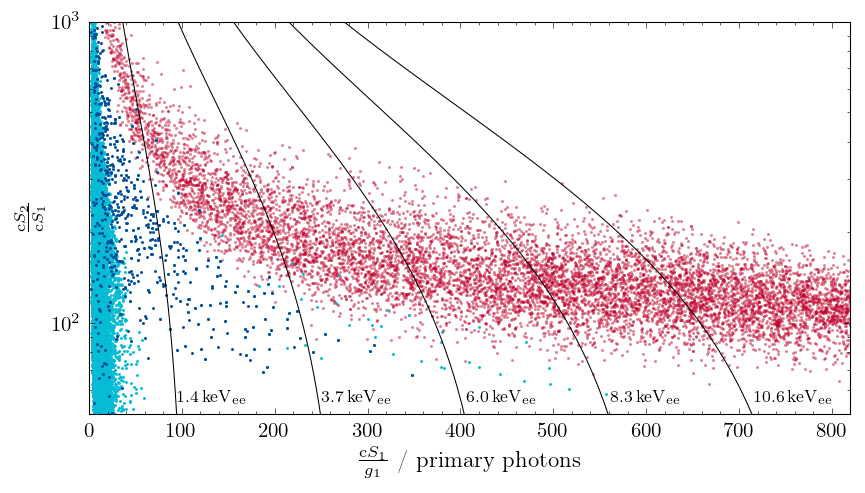

In [8]:


if [False,True][1]:


    sfs.gen_signature_plot(
        signature_dict_list = [
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_test_detector__er_background.npy"),
                "label" : r"combined ER background",
                "alpha" : 0.5,
                "facecolors" : sfs.color_ers_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_test_detector__nr_background.npy"),
                "label" : r"combined NR background",
                "alpha" : 1,
                "facecolors" : sfs.color_nrs_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_test_detector__wimps.npy"),
                "label" : r"WIMPs",
                "alpha" : 1,
                "zorder" : 3,
                "facecolors" : sfs.color_wimps_default,
            },
        ],
        detector_dict = darwin_baseline_detector_dict,
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        **[
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [],
                "F" : [],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][0],
            },
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,820],
                "plot_ylim" : [5e+1, 1e+3],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][1],
            },
        ][1],
        plot_energy_contours = list(np.linspace(start=wimp_eroi_kev_ee[0], stop=wimp_eroi_kev_ee[1], num=5, endpoint=True)),
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__signature_plot__combined_er_nr_spectra_wimps.png",
        flag_profile = ["default"][0],
        flag_verbose = True,
    )





<br>
<br>


# ER/NR Discrimination


<br>
<br>




<br>
<br>


# Maximum Likelihood Sensitivity Estimation


<br>
<br>

